In [1]:
import backtrader as bt
import alpaca_backtrader_api as api
import alpaca_trade_api as tradeapi
import pandas as pd

from config import key_id, secret_key



In [2]:

from typing import Dict, List
from functools import reduce
from pandas import DataFrame
# --------------------------------
import talib.abstract as tab
from typing import Dict, List
from pandas import DataFrame, DatetimeIndex, merge
# --------------------------------
import talib as ta
import numpy  # noqa


In [3]:
api = tradeapi.REST(key_id, secret_key)

In [4]:
#get data and turn to dataframe form
#15Min, 5Min
data=api.get_barset(symbols = ("INTC"), start = '2020-03-27T11:52:00-04:00', end = "2020-01-01", timeframe = "minute", limit=1000)
df=data.df #converts to dataframe

In [5]:
#get rid of multiindex, otherwise backtrader will have problems
df=df.INTC

In [6]:
#form is not compatible with bt strategy but should work with bot algo when that happens
from pandas import DataFrame
def populateindicators(dataframe) -> DataFrame:
        dataframe['ema_high'] = tab.EMA(dataframe, timeperiod=5, price='high')
        dataframe['ema_close'] = tab.EMA(dataframe, timeperiod=5, price='close')
        dataframe['ema_low'] = tab.EMA(dataframe, timeperiod=5, price='low')
        stoch_fast = tab.STOCHF(dataframe, 10.0, 3.0, 0.0, 3.0, 0.0)
        dataframe['fastd'] = stoch_fast['fastd']
        dataframe['fastk'] = stoch_fast['fastk']
        dataframe['adx'] = tab.ADX(dataframe)

        # required for graphing
        bollinger =ta.BBANDS(dataframe.close,timeperiod=10)
        dataframe['bb_lowerband'] = bollinger[2]
        dataframe['bb_upperband'] = bollinger[0]
        dataframe['bb_middleband'] = bollinger[1]

        return dataframe

In [7]:
#feed strat to cerebro

class Scalp(bt.Strategy):
    """
        this strategy is based around the idea of generating a lot of potential buys and make tiny profits on each trade
        we recommend to have at least 60 parallel trades at any time to cover non avoidable losses.
        Recommended is to only sell based on ROI for this strategy
    """ 
#populate a dataframe with indicators
    
    
    
#------------------------------------strategy starts here--------------------------------------------------------------    
    def __init__(self):
        #populate exponential moving averages
        self.emahigh=bt.indicators.EMA(self.data.high, period=10)
        self.emaclose=bt.indicators.EMA(self.data.close, period=10)
        self.emalow=bt.indicators.EMA(self.data.low, period=10)
        
        #creat stochastic momentum indicators 
        self.stoch=bt.talib.STOCHF(self.data.high, self.data.low, self.data.close, \
                                   fastk_period=14, slowk_period=4, slowd_period=4)
        self.fastk=self.stoch.fastk
        self.fastd=self.stoch.fastd
        #create Average Directional Movement Index
        self.adx=bt.talib.ADX(self.data.high, self.data.low, self.data.close, timeperiod=14)
        
        
# if open score is less than ema_low, adx is greater than 30, fastk fastd less than 30, then buy
#uses indicators to determine buy and sell

    def next(self):
        if not self.position: #not in the market
            if self.data.open < self.emalow and \
            self.adx > 30 and \
            self.fastk < 30 and \
            self.fastd < 30:
                self.buy(size=200)
                
                
        else:
            if self.data.open >= self.emahigh and \
            self.fastk > 70 and \
            self.fastd > 70:
                self.sell(size=200)


In [8]:

#feed dataframe to cerbro
datacere = bt.feeds.PandasData(dataname=df)

#create backtrader
cerebro = bt.Cerebro()

#cerebro.addstrategy(SmaCross)
cerebro.addstrategy(Scalp)

#Add slippage
cerebro.broker = bt.brokers.BackBroker(slip_perc=0.005) 

#set up cerebro

cerebro.broker.setcash(100000)

cerebro.broker.setcommission(commission=0.0)
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)
cerebro.adddata(datacere)



In [9]:
#create plotinfo dict for plotting options
plotinfo = dict(plot=True,
                subplot=True,
                plotname='',
                plotskip=False,
                plotabove=False,
                plotlinelabels=False,
                plotlinevalues=True,
                plotvaluetags=True,
                plotymargin=0.0,
                plotyhlines=[],
                plotyticks=[],
                plothlines=[],
                plotforce=False,
                plotmaster=None,
                plotylimited=True,
           )

In [10]:
#change window settings
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 20, 15  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "20"

In [11]:
#Add indicators 

#adding another simple moving average line; this is the backtrader built in indicator
sma = bt.indicators.SimpleMovingAverage(datacere, period=15)
sma.plotinfo.plotname = 'mysma'


macd= bt.indicators.MACD(datacere)
macd.plotinfo.plotname="MACD"
#https://www.backtrader.com/docu/indautoref/
#custom: https://medium.com/@danjrod/custom-indicator-development-in-python-with-backtrader-bc775552dc3e

In [12]:
# Add the analyzers we are interested in
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
cerebro.addanalyzer(bt.analyzers.Returns, _name="ret")
cerebro.addanalyzer(bt.analyzers.PeriodStats, _name="pstat")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="trans")



In [13]:
# Add the observers we are interested in 
#this adds more things to the plot on top of the stocks chart
cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.BuySell)


<IPython.core.display.Javascript object>


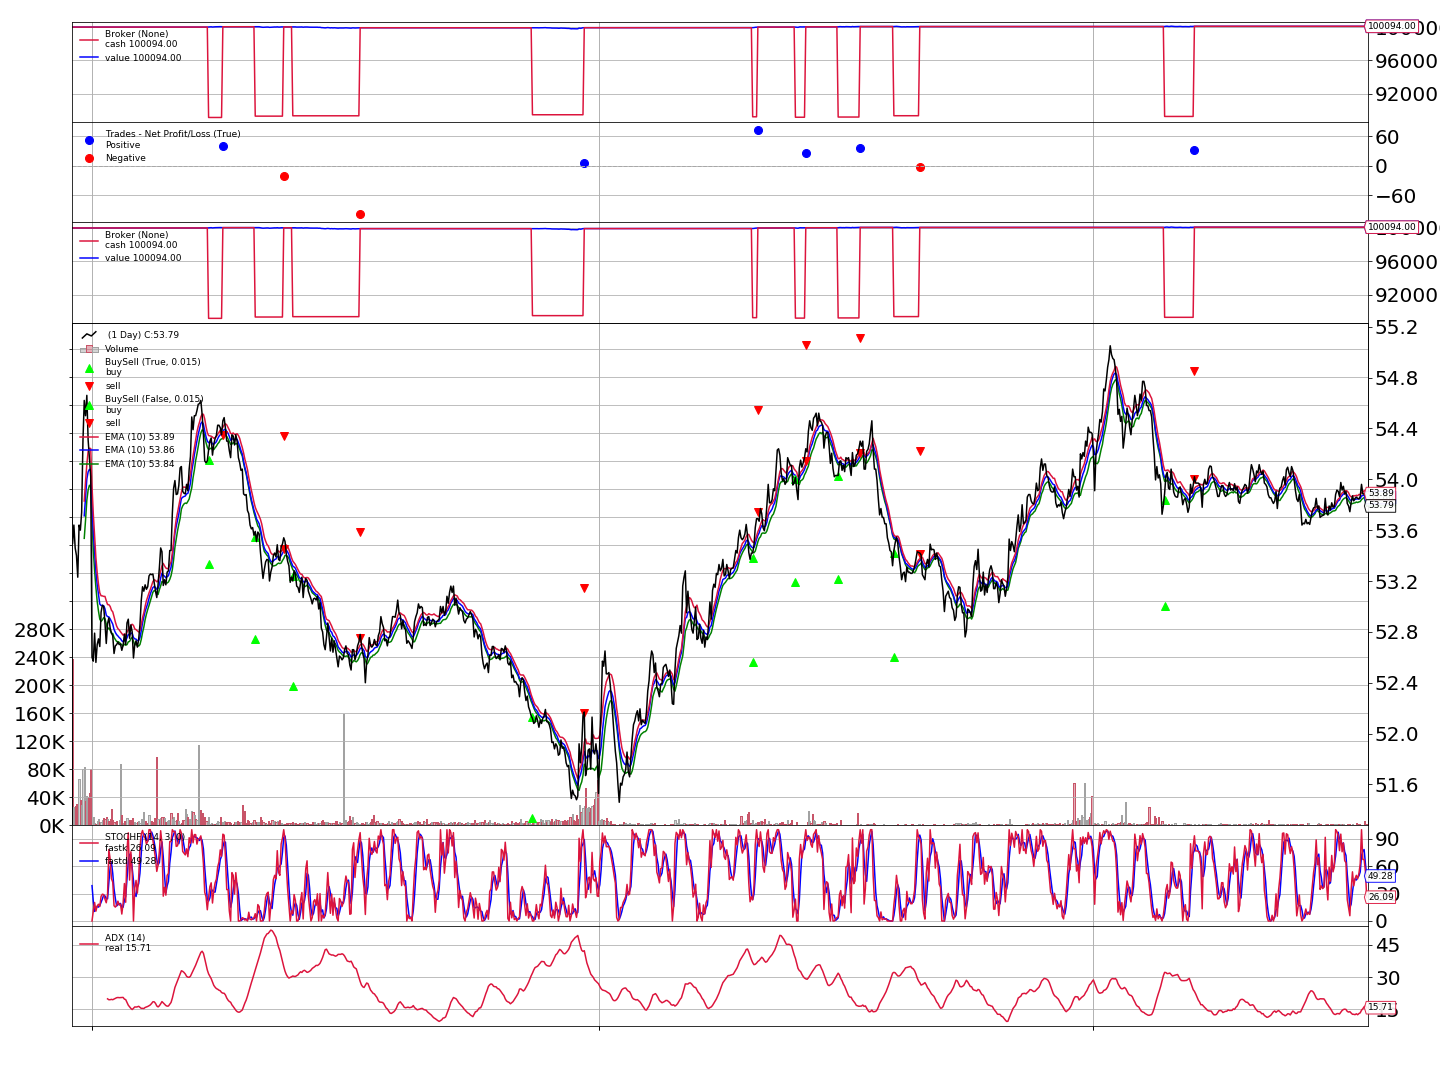

[[<Figure size 1440x1080 with 7 Axes>]]

In [14]:
# Run over everything
test=cerebro.run()

# Plot the result
cerebro.plot()


## Analyzers


In [16]:
# print the SQN analyzers  SystemQualityNumber
#test[0] is the first strategy used. For multiple strategies, use corresponding number in the list.
SQN_dict=test[0].analyzers.sqn.get_analysis() 
tradeanalysis_dict=test[0].analyzers.ta.get_analysis()
ret_dict=test[0].analyzers.ret.get_analysis()
trans_dict=test[0].analyzers.trans.get_analysis()

#.ta.get_analysis()
    #printSQN(firstStrat.analyzers.sqn.get_analysis())

    
#The Backtrader documentation provides a helpful ranking system for SQN:
#SQN measures the relationship between the mean (expectancy) and the standard deviation of the R-multiple distribution 
#generated by a trading system. It also makes an adjustment for the number of trades involved.
#    0 and under is BAD
#    1.6 – 1.9 Below average
#    2.0 – 2.4 Average
#    2.5 – 2.9 Good
#    3.0 – 5.0 Excellent
#    5.1 – 6.9 Superb
#    7.0 – Holy Grail?


In [17]:
SQN_dict

AutoOrderedDict([('sqn', 0.682518675186103), ('trades', 9)])

In [18]:
ret_dict #in percentages

OrderedDict([('rtot', 0.0009395584766662337),
             ('ravg', 0.00023488961916655842),
             ('rnorm', 0.06097912439178312),
             ('rnorm100', 6.097912439178312)])

In [19]:
tradeanalysis_dict
#pnl stands for profit and loss

AutoOrderedDict([('total',
                  AutoOrderedDict([('total', 9), ('open', 0), ('closed', 9)])),
                 ('streak',
                  AutoOrderedDict([('won',
                                    AutoOrderedDict([('current', 1),
                                                     ('longest', 4)])),
                                   ('lost',
                                    AutoOrderedDict([('current', 0),
                                                     ('longest', 2)]))])),
                 ('pnl',
                  AutoOrderedDict([('gross',
                                    AutoOrderedDict([('total',
                                                      93.99999999999835),
                                                     ('average',
                                                      10.444444444444262)])),
                                   ('net',
                                    AutoOrderedDict([('total',
                                     

In [19]:
trans_dict


OrderedDict([(datetime.datetime(2020, 4, 1, 13, 42),
              [[100, 52.945, 0, '', -5294.5]]),
             (datetime.datetime(2020, 4, 1, 14, 0),
              [[-100, 52.84, 0, '', 5284.0]]),
             (datetime.datetime(2020, 4, 1, 14, 59),
              [[100, 54.15, 0, '', -5415.0]]),
             (datetime.datetime(2020, 4, 1, 15, 10),
              [[-100, 54.35, 0, '', 5435.0]]),
             (datetime.datetime(2020, 4, 1, 15, 35),
              [[100, 53.55, 0, '', -5355.0]]),
             (datetime.datetime(2020, 4, 1, 15, 57),
              [[-100, 53.45, 0, '', 5345.0]]),
             (datetime.datetime(2020, 4, 1, 16, 4),
              [[100, 53.24, 0, '', -5324.0]]),
             (datetime.datetime(2020, 4, 1, 16, 56),
              [[-100, 52.75, 0, '', 5275.0]]),
             (datetime.datetime(2020, 4, 1, 19, 9),
              [[100, 52.13, 0, '', -5213.0]]),
             (datetime.datetime(2020, 4, 1, 19, 49),
              [[-100, 52.16, 0, '', 5216.0]]),
  

In [20]:
trans_df = pd.DataFrame(trans_dict)
trans_df=trans_df.transpose()
trans_df.head()

#'date', 'amount', 'price', 'sid'(0), 'symbol'(empty), 'value'

,0
2020-04-01 13:42:00,"[100, 52.945, 0, , -5294.5]"
2020-04-01 14:00:00,"[-100, 52.84, 0, , 5284.0]"
2020-04-01 14:59:00,"[100, 54.15, 0, , -5415.0]"
2020-04-01 15:10:00,"[-100, 54.35, 0, , 5435.0]"
2020-04-01 15:35:00,"[100, 53.55, 0, , -5355.0]"


In [21]:
trans_df[0][0:][0]

[100, 52.945, 0, '', -5294.5]